In [5]:
library(reticulate)
use_condaenv(condaenv="pyr2", conda="/data8t_0/hms/anaconda3/bin/conda")
# umap<-import('umap')

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
datasetName = "Kidney_AdjacentNormalTissue_HCLAdultKidney2"
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)

setwd("/stor/public/hcad/Kidney_AdjacentNormalTissue_HCLAdultKidney2/")

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [9]:
system(paste0('/data8t_0/hms/anaconda3/envs/pyr2/bin/python /data8t_0/hms/workspace/GeneSymbolUniform_v0.4.py ',"\"",datasetName,"\""))

In [6]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"),h = T,sep='\t',row.names = 1)
} else if(dataFormat == 'uni')
    {
    data.matrix <- read.csv("UniformedExpression.csv",h = T,sep='\t',row.names = 1)
}else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tsv.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [31]:
nrow(data.matrix)

[1] 43878

In [12]:
data.query = read.csv("ModificationReport.csv",h = T,sep='\t',row.names = 1)

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


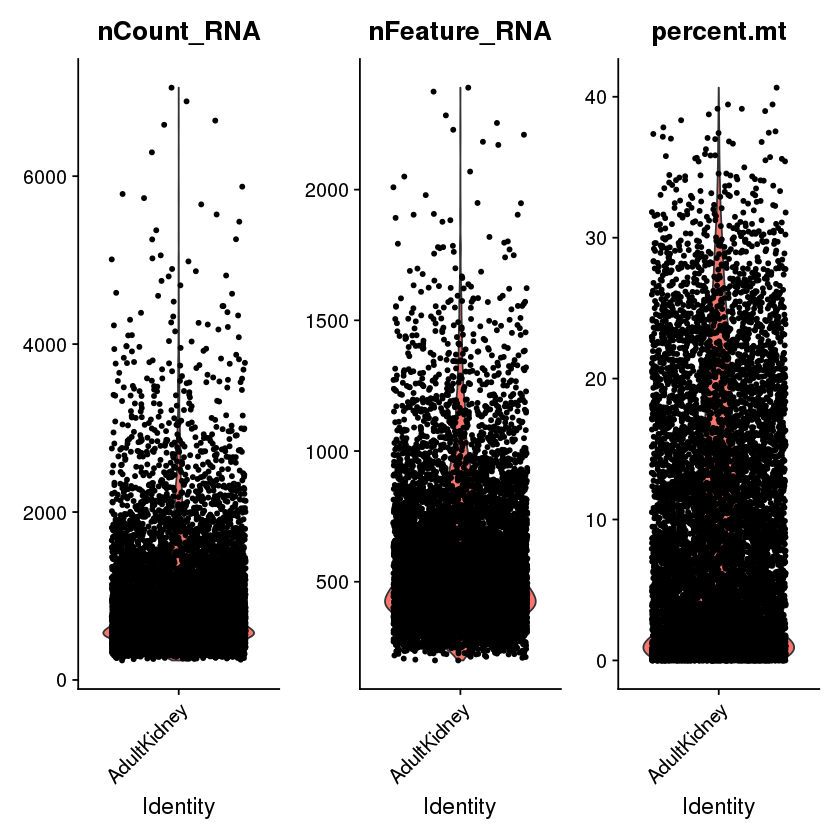

In [7]:
# Pre-processing
min.cells = 50
min.features = 200
nFeature_RNA_range = c(min.features, 600)
percent.mt.thre = 1
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

# QC
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [8]:
dataobj

An object of class Seurat 
10784 features across 9153 samples within 1 assay 
Active assay: RNA (10784 features, 0 variable features)

In [9]:
percent.mt.thre = 50
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)
dataobj

An object of class Seurat 
10784 features across 6028 samples within 1 assay 
Active assay: RNA (10784 features, 0 variable features)

In [7]:
warnings('off')
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



PC_ 1 
Positive:  HLA-DRA, CD74, HLA-DPA1, HLA-DPB1, HLA-DRB1, SRGN, HLA-DQA1, AIF1, TYROBP, FCER1G 
	   LYZ, GPR183, HLA-DQB1, BCL2A1, CXCL8, LAPTM5, SLC2A3, MS4A6A, CTSS, CD53 
	   C15orf48, RGS1, GMFG, OLR1, LST1, FTH1, S100A4, TMSB4X, IL1B, CXCR4 
Negative:  MT-ATP6, MT-ND4, MT-ND2, MT-ND5, MT1E, MT-ND3, MT-CO2, MTATP6P1, MT-RNR1, MT1G 
	   COX7C, MT-ND4L, MT1X, SMIM24, MT1F, CXCL14, MT1H, TSPAN1, GPX3, PDZK1IP1 
	   MT2A, DEFB1, KRT18, SLC3A1, OCIAD2, MGST1, COX7B, CLTRN, CXXC1, UGT2B7 
PC_ 2 
Positive:  IGFBP5, IFI27, A2M, SPARC, FLT1, TM4SF1, EMCN, THBD, TGFBR2, PLVAP 
	   PLPP3, PTPRB, RAMP3, GNG11, TIMP3, DNASE1L3, PECAM1, PLAT, LRRC32, PCAT19 
	   PLPP1, GJA1, CEACAM1, SELE, EMP1, RAMP2, TEK, CAVIN2, SOCS3, KDR 
Negative:  FTH1, TYROBP, FCER1G, LYZ, SRGN, AIF1, HLA-DRA, FTL, GPR183, BCL2A1 
	   C15orf48, CXCL8, HLA-DRB1, MS4A6A, OLR1, CTSS, LST1, RGS1, CST3, CD53 
	   IL1B, PLEK, FABP5P1, CD86, LAPTM5, IL1RN, CSTA, JAML, CCL3, TMSB4X 
PC_ 3 
Positive:  MT1G, MT1H, PDZK1IP1, C

png 
  2

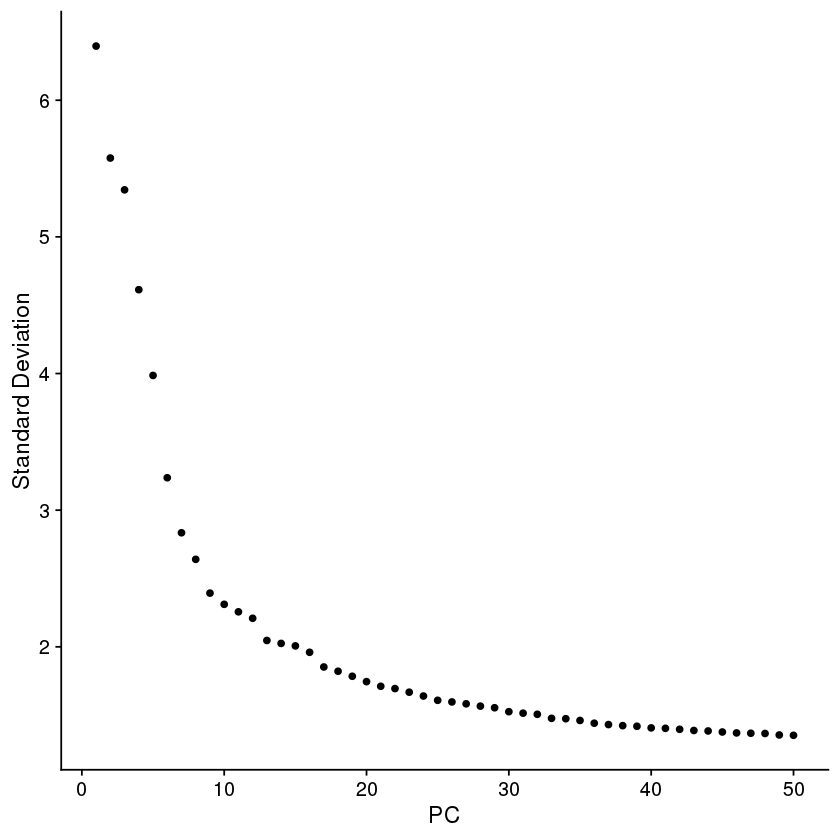

In [8]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj),npcs=50)
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj,ndim=50) 
dev.off()
ElbowPlot(dataobj,ndim=50) 

In [9]:
pcDim = 40 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph

Computing SNN



In [12]:
dataobj <- FindClusters(dataobj, resolution = 0.5, n.start = 5)
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9153
Number of edges: 386726

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.9072
Number of communities: 15
Elapsed time: 0 seconds


ARI 
0.6772466

In [13]:
rr <- RunUMAP(dataobj,dims=1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
09:29:47 UMAP embedding parameters a = 0.9922 b = 1.112

09:29:47 Read 9153 rows and found 40 numeric columns

09:29:47 Using Annoy for neighbor search, n_neighbors = 30

09:29:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

09:29:50 Writing NN index file to temp file /tmp/RtmptWcbT7/file41adc6c1e4

09:29:50 Searching Annoy index using 1 thread, search_k = 3000

09:29:53 Annoy recall = 100%

09:29:53 Commencing smooth kNN distance calibration using 1 thread

09:29:55 Initializing from

Warning message:
“Using `as.character()` on a quosure is deprecated as of rlang 0.3.0.
Please use `as_label()` or `as_name()` instead.
This warning is displayed once per session.”


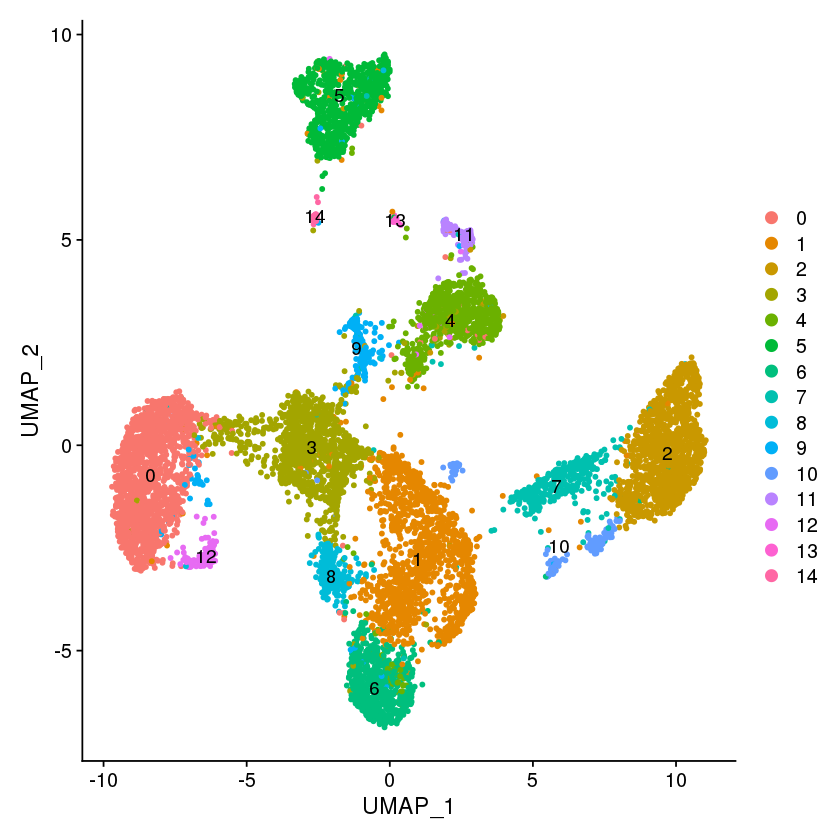

In [14]:
p_umap=DimPlot(rr,label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)
p_umap

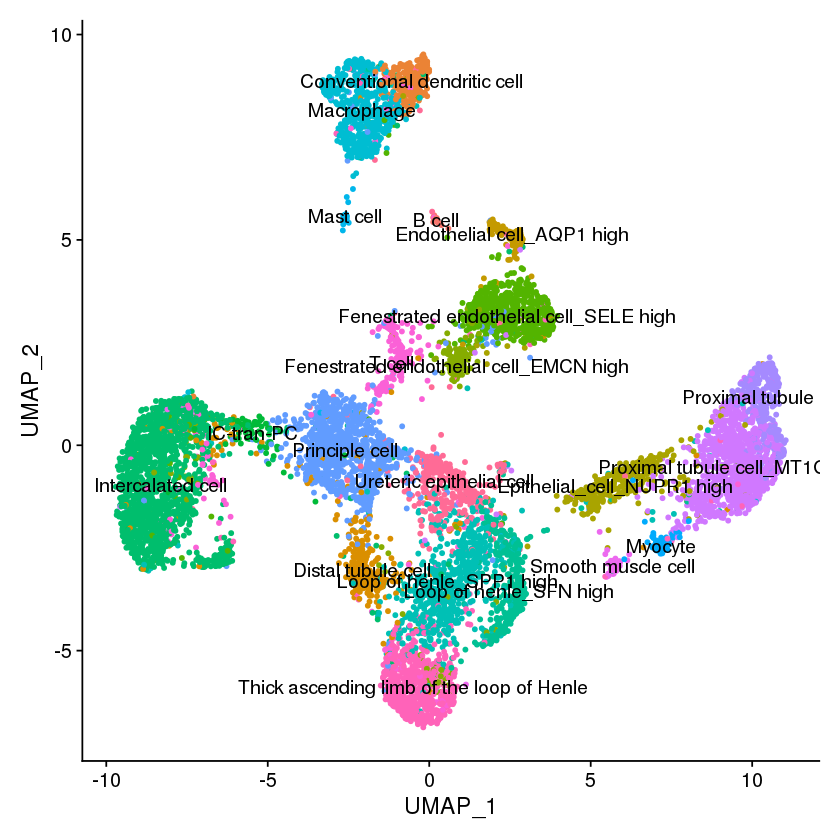

In [15]:
p_umap2 <- DimPlot(rr, reduction = "umap", label = T, group.by = "cell_cluster", pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)
p_umap2

In [24]:
new.cluster.ids <- c("Kidney-Epithelial tissue-Intercalated cell-ATP6V1G3",
                     "Kidney-Epithelial tissue-Loop of Henle-CXXC1", 
                     "Kidney-Epithelial tissue-Proximal convoluted tubule-ALDOB", 
                     "Kidney-Epithelial tissue-Principle cell-GATM", 
                     "Kidney-Epithelial tissue-Endothelial cell-SELE",
                     "Kidney-Connective tissue-Macrophage-APOC1",
                     "Kidney-Epithelial tissue-Loop of Henle-SLC12A1", 
                     "Kidney-Epithelial tissue-Epithelial cell-NUPR1",
                     "Kidney-Epithelial tissue-Distal convoluted tubule-SLC12A3", 
                     "Kidney-Connective tissue-T cell-TRAC", 
                     "Kidney-Muscle tissue-Smooth muscle cell-BGN",
                     "Kidney-Epithelial tissue-Epithelial cell-AQP1",
                     "Kidney-Epithelial tissue-Intercalated cell-ATP6V1G3", 
                     "Kidney-Connective tissue-B cell-JCHAIN",
                    "Kidney-Connective tissue-Mast cell-CPA4"
                    )

In [83]:
qq=c('','')
for (i in new.cluster.ids){
    tmp = unlist(strsplit(i,split='-'))[4]
    if(tmp!=as.character(data.query[which(data.query$Original.Name==tmp),"Modified.Name"]))
    qq = append(qq,c(tmp,as.character(data.query[which(data.query$Original.Name==tmp),"Modified.Name"])))
}
qq

[1] ""      ""      "SPP1"  "CXXC1" "SFN"   "REXO2"

In [25]:
subset(dataobj.markers,cluster=='14')
# subset(dataobj.markers,gene=='SLC12A1')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
TPSB2,0.000000e+00,5.0431662,0.96,0.004,0.000000e+00,14,TPSB2
TPSAB1,0.000000e+00,4.9248090,1.00,0.005,0.000000e+00,14,TPSAB1
CTSG,0.000000e+00,4.7393192,0.92,0.004,0.000000e+00,14,CTSG
CPA4,0.000000e+00,3.7630623,0.96,0.004,0.000000e+00,14,CPA4
HPGDS,0.000000e+00,2.6570492,0.68,0.004,0.000000e+00,14,HPGDS
HPGD,6.010909e-124,2.9031430,0.64,0.016,6.208668e-120,14,HPGD
RGS18,7.834232e-115,1.7983724,0.40,0.006,8.091978e-111,14,RGS18
PTGS21,2.512453e-95,2.5134419,0.64,0.021,2.595112e-91,14,PTGS2
IL1RL1,2.487572e-89,2.0132690,0.44,0.010,2.569413e-85,14,IL1RL1


In [26]:
names(x = new.cluster.ids) <- levels(x = dataobj)
annodataobj <- RenameIdents(object = dataobj, new.cluster.ids)

In [27]:
rr2 <- RunUMAP(annodataobj,dims=1:pcDim)

09:39:59 UMAP embedding parameters a = 0.9922 b = 1.112

09:39:59 Read 9153 rows and found 40 numeric columns

09:39:59 Using Annoy for neighbor search, n_neighbors = 30

09:39:59 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

09:40:02 Writing NN index file to temp file /tmp/RtmptWcbT7/file41a631d9750

09:40:02 Searching Annoy index using 1 thread, search_k = 3000

09:40:05 Annoy recall = 100%

09:40:06 Commencing smooth kNN distance calibration using 1 thread

09:40:07 Initializing from normalized Laplacian + noise

09:40:07 Commencing optimization for 500 epochs, with 409642 positive edges

09:40:40 Optimization finished



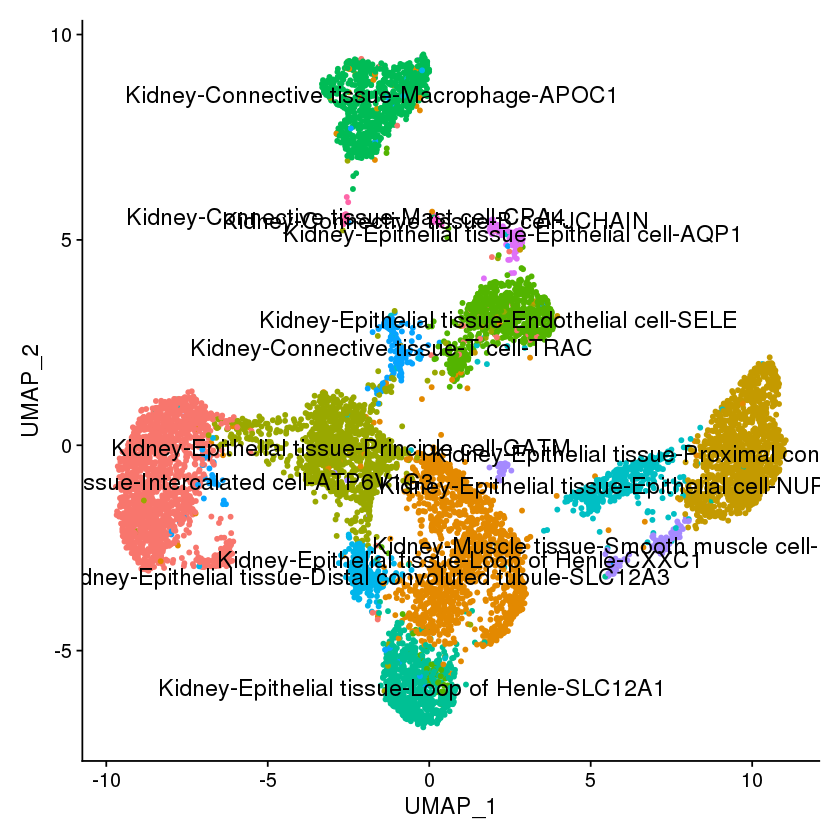

In [28]:
p_umap4 <- UMAPPlot(rr2,label = T, pt.size=1,label.size=5)+NoLegend()
# LabelClusters(plot = p_umap4, id = 'ident', color = 'white')
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap4, width = 25, height = 15)
p_umap4

In [16]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14



In [41]:
dataobj.dbupload_v1 <- CreateSeuratObject(data.matrix, min.features = 200)
dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v1[['orig.ident']] <- NULL
dataobj.dbupload_v1[['nCount_RNA']] <- NULL
dataobj.dbupload_v1[['nFeature_RNA']] <- NULL

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [5]:
dataobj.dbupload_v1 <- CreateSeuratObject(dataobj.dbupload_v1@assays$RNA@data)
# dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v1[['orig.ident']] <- NULL
dataobj.dbupload_v1[['nCount_RNA']] <- NULL
dataobj.dbupload_v1[['nFeature_RNA']] <- NULL
dataobj.dbupload_v1$user_id <- 1
dataobj.dbupload_v1$study_id<-"10.1038/s41586-020-2157-7"
dataobj.dbupload_v1$cell_id <- colnames(dataobj.dbupload_v1@assays$RNA@data)
dataobj.dbupload_v1$organ<-"Kidney"
dataobj.dbupload_v1$region<-"NA"
dataobj.dbupload_v1$subgion<-"NA"
dataobj.dbupload_v1$seq_tech<-"Microwell-seq"
dataobj.dbupload_v1$sample_status<-"Healthy"
dataobj.dbupload_v1$donor_id<-dataobj2$donor_ID
dataobj.dbupload_v1$donor_gender<-dataobj2$donor_gender
dataobj.dbupload_v1$donor_age<- dataobj2$donor_age
dataobj.dbupload_v1$original_name<-dataobj2$cell_cluster
dataobj.dbupload_v1$cl_name<-"NA"
dataobj.dbupload_v1$hcad_name<-dataobj2$hcad.label

In [6]:
dataobj.dbupload_v1$original_name<-as.character(dataobj.dbupload_v1$original_name)
dataobj.dbupload_v1$donor_id<-as.character(dataobj.dbupload_v1$donor_id)
dataobj.dbupload_v1$donor_gender<-as.character(dataobj.dbupload_v1$donor_gender)
dataobj.dbupload_v1$donor_age<- sub("Y","yr",dataobj.dbupload_v1$donor_age)


In [7]:
dataobj.dbupload_v1[[]]

,user_id,study_id,cell_id,organ,region,subgion,seq_tech,sample_status,donor_id,donor_gender,donor_age,original_name,cl_name,hcad_name
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AdultKidney_2.AAAACGAAAACGCATGAT,1,10.1038/s41586-020-2157-7,AdultKidney_2.AAAACGAAAACGCATGAT,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Loop of henle_SPP1 high,NA,Kidney-Epithelial tissue-Loop of Henle-CXXC1
AdultKidney_2.AAAACGACGTTGGAATTA,1,10.1038/s41586-020-2157-7,AdultKidney_2.AAAACGACGTTGGAATTA,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Intercalated cell,NA,Kidney-Epithelial tissue-Intercalated cell-ATP6V1G3
AdultKidney_2.AAAACGAGCGAGAACCTA,1,10.1038/s41586-020-2157-7,AdultKidney_2.AAAACGAGCGAGAACCTA,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Proximal tubule cell_MT1G high,NA,Kidney-Epithelial tissue-Proximal convoluted tubule-ALDOB
AdultKidney_2.AAAACGAGCGAGTCACTT,1,10.1038/s41586-020-2157-7,AdultKidney_2.AAAACGAGCGAGTCACTT,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Intercalated cell,NA,Kidney-Epithelial tissue-Intercalated cell-ATP6V1G3
AdultKidney_2.AAAACGAGGACTATTTGC,1,10.1038/s41586-020-2157-7,AdultKidney_2.AAAACGAGGACTATTTGC,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Macrophage,NA,Kidney-Connective tissue-Macrophage-APOC1
AdultKidney_2.AAAACGAGTTTAGCGTCC,1,10.1038/s41586-020-2157-7,AdultKidney_2.AAAACGAGTTTAGCGTCC,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Fenestrated endothelial cell_SELE high,NA,Kidney-Epithelial tissue-Endothelial cell-SELE
AdultKidney_2.AAAACGATACAGCTCGCA,1,10.1038/s41586-020-2157-7,AdultKidney_2.AAAACGATACAGCTCGCA,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Thick ascending limb of the loop of Henle,NA,Kidney-Epithelial tissue-Loop of Henle-SLC12A1
AdultKidney_2.AAAACGATCAACTTCCGC,1,10.1038/s41586-020-2157-7,AdultKidney_2.AAAACGATCAACTTCCGC,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Intercalated cell,NA,Kidney-Epithelial tissue-Intercalated cell-ATP6V1G3
AdultKidney_2.AAAACGATCTCTGCCCTC,1,10.1038/s41586-020-2157-7,AdultKidney_2.AAAACGATCTCTGCCCTC,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Proximal tubule cell,NA,Kidney-Epithelial tissue-Proximal convoluted tubule-ALDOB


In [50]:

write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(annodataobj@active.ident),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [10]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [3]:
dataobj2 <-readRDS(paste0(datasetName,".seuratobj.rds"))

In [3]:
dataobj.dbupload_v1 <-readRDS(paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [6]:
dataobj.dbupload_v1$study_id<-"10.1038/s41586-020-2157-4"

In [ ]:
dataobj.dbupload_v1$region<-"NA"

In [14]:
colnames(dataobj.dbupload_v1@meta.data)

[1] "study_id"      "organ"         "region"        "subgion"      
 [5] "seq_tech"      "sample_status" "donor_id"      "donor_gender" 
 [9] "donor_age"     "original_name" "cl_name"       "hcad_name"    
[13] "user_id"       "cell_id"

In [8]:
head(dataobj.dbupload_v1[[]])

,user_id,study_id,cell_id,organ,region,subgion,seq_tech,sample_status,donor_id,donor_gender,donor_age,original_name,cl_name,hcad_name
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
AdultKidney_2.AAAACGAAAACGCATGAT,1,10.1038/s41586-020-2157-4,AdultKidney_2.AAAACGAAAACGCATGAT,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Loop of henle_SPP1 high,NA,Kidney-Epithelial tissue-Loop of Henle-CXXC1
AdultKidney_2.AAAACGACGTTGGAATTA,1,10.1038/s41586-020-2157-4,AdultKidney_2.AAAACGACGTTGGAATTA,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Intercalated cell,NA,Kidney-Epithelial tissue-Intercalated cell-ATP6V1G3
AdultKidney_2.AAAACGAGCGAGAACCTA,1,10.1038/s41586-020-2157-4,AdultKidney_2.AAAACGAGCGAGAACCTA,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Proximal tubule cell_MT1G high,NA,Kidney-Epithelial tissue-Proximal convoluted tubule-ALDOB
AdultKidney_2.AAAACGAGCGAGTCACTT,1,10.1038/s41586-020-2157-4,AdultKidney_2.AAAACGAGCGAGTCACTT,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Intercalated cell,NA,Kidney-Epithelial tissue-Intercalated cell-ATP6V1G3
AdultKidney_2.AAAACGAGGACTATTTGC,1,10.1038/s41586-020-2157-4,AdultKidney_2.AAAACGAGGACTATTTGC,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Macrophage,NA,Kidney-Connective tissue-Macrophage-APOC1
AdultKidney_2.AAAACGAGTTTAGCGTCC,1,10.1038/s41586-020-2157-4,AdultKidney_2.AAAACGAGTTTAGCGTCC,Kidney,NA,NA,Microwell-seq,Healthy,AdultKidney_66Y,Male,66yr,Fenestrated endothelial cell_SELE high,NA,Kidney-Epithelial tissue-Endothelial cell-SELE


In [12]:
nrow(dataobj.dbupload_v1@meta.data)

[1] 9153

In [8]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [9]:
dataobj.dbupload_v1

An object of class Seurat 
43878 features across 9153 samples within 1 assay 
Active assay: RNA (43878 features, 0 variable features)